# 04. EDA & Visualization for Top-Down Strategy

---

## 분석 구조

### Group 1: 분포 분석
1. 히스토그램
2. 박스플롯

### Group 2: 관계 분석 
4. 산점도
5. 산점도 행렬
6. 페어 플롯
7. 정규성 검정
8. 상관관계 히트맵

### Group 3: 시계열 패턴 
9. 시계열 분해
10. ADF Test(단위근 검정)
10. 자기상관함수
11. 부분자기상관함수

### Group 4: 섹터/기업 비교
12. Sector Performance Heatmap
13. Top/Bottom Performers
14. Risk-Return Scatter

---

## Section 1. 환경 설정 & 데이터 로드

In [20]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import os

# 통계 분석
from scipy import stats
from scipy.stats import probplot, normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

warnings.filterwarnings('ignore')

# 시각화 스타일
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# 한글 폰트 설정
import koreanize_matplotlib
pkg_dir = os.path.dirname(koreanize_matplotlib.__file__)
font_path = os.path.join(pkg_dir, 'fonts', 'NanumGothic.ttf')

# 폰트 등록 및 설정
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"Font registered: {font_name}")
print(f"Font family: {plt.rcParams['font.family']}")

Font registered: NanumGothic
Font family: ['NanumGothic']


In [21]:
# 경로 설정
PROJECT_ROOT = Path('.').resolve()
DATA_DIR = PROJECT_ROOT / 'Data_set'
VIZ_DIR = DATA_DIR / 'Visualizations'
TABLEAU_DIR = DATA_DIR / 'Tableau_Ready'

# 디렉토리 생성
VIZ_DIR.mkdir(exist_ok=True)
TABLEAU_DIR.mkdir(exist_ok=True)

In [22]:
# 데이터 로드
df = pd.read_csv(DATA_DIR / 'stock_daily_master.csv')
df['Date'] = pd.to_datetime(df['Date'])

---

## Section 2. Group 1 - 분포 분석

### 2.1 히스토그램

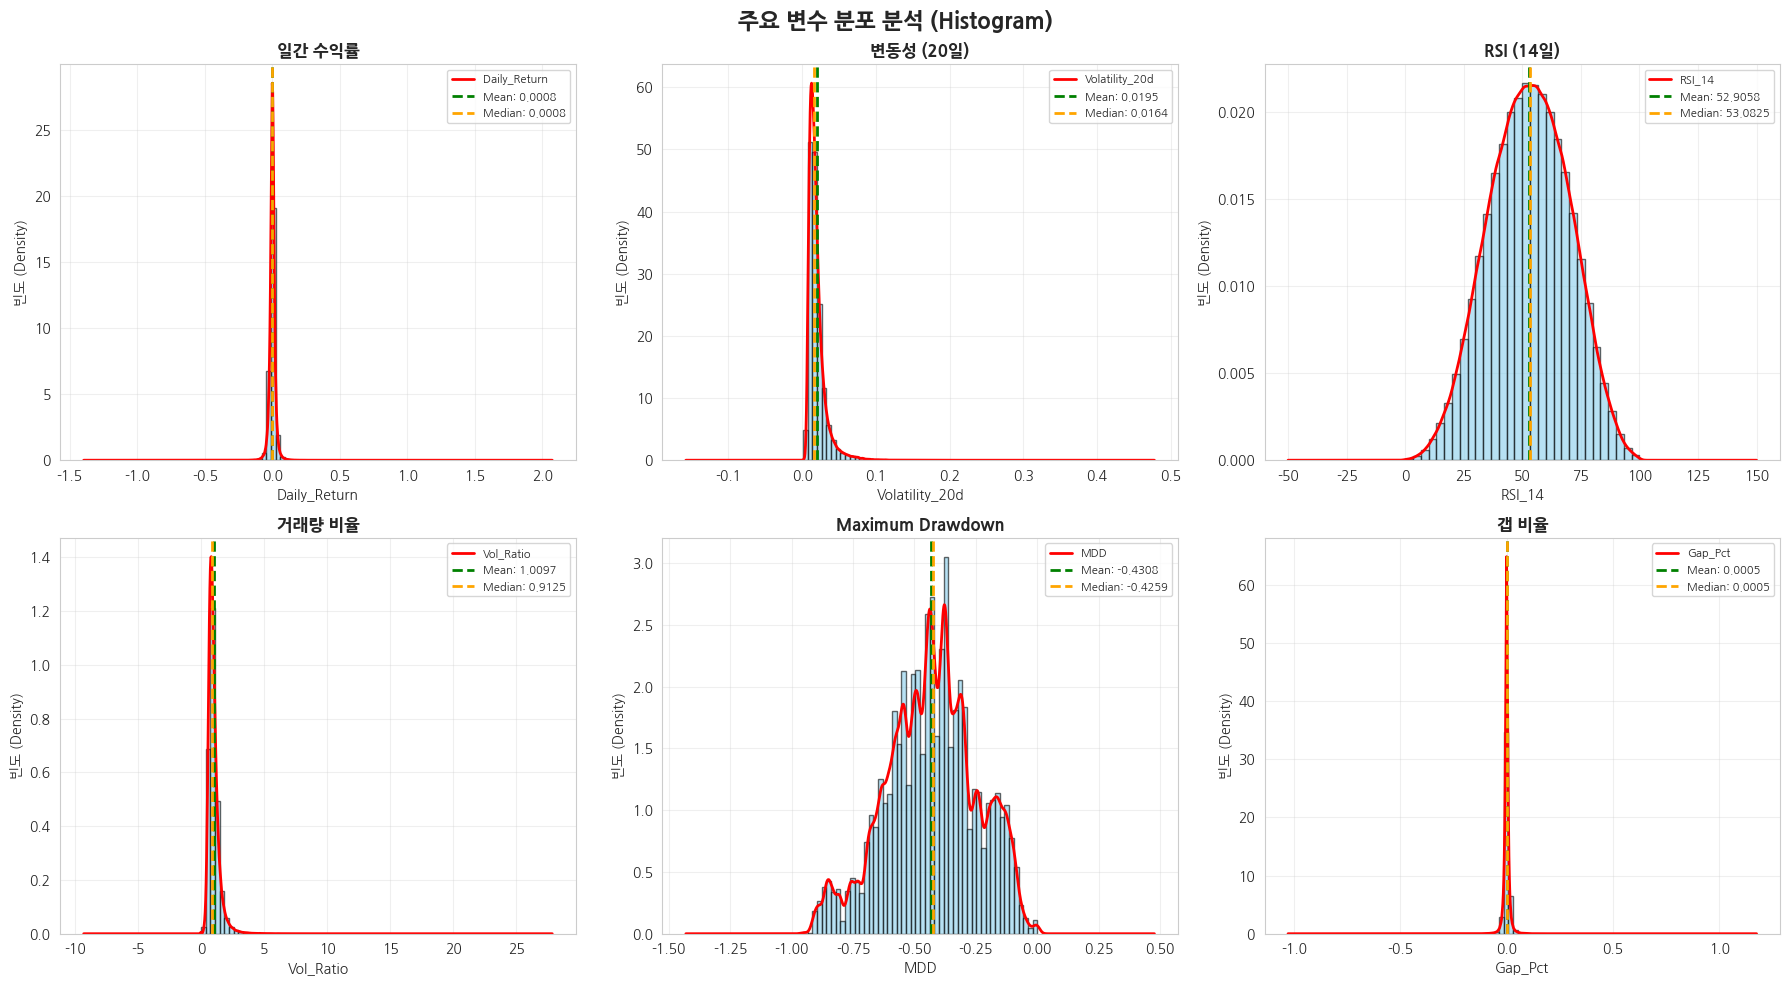

In [23]:
# 주요 변수 히스토그램
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('주요 변수 분포 분석 (Histogram)', fontsize=16, fontweight='bold')

variables = [
    ('Daily_Return', '일간 수익률', 50),
    ('Volatility_20d', '변동성 (20일)', 50),
    ('RSI_14', 'RSI (14일)', 30),
    ('Vol_Ratio', '거래량 비율', 50),
    ('MDD', 'Maximum Drawdown', 50),
    ('Gap_Pct', '갭 비율', 50)
]

for idx, (col, title, bins) in enumerate(variables):
    ax = axes[idx // 3, idx % 3]
    
    # 결측치 제거
    data = df[col].dropna()
    
    # 히스토그램 + KDE
    ax.hist(data, bins=bins, alpha=0.6, color='skyblue', edgecolor='black', density=True)
    
    # KDE 곡선
    data.plot(kind='kde', ax=ax, color='red', linewidth=2, secondary_y=False)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('빈도 (Density)')
    ax.grid(True, alpha=0.3)
    
    # 통계량 표시
    mean = data.mean()
    median = data.median()
    std = data.std()
    
    ax.axvline(mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean:.4f}')
    ax.axvline(median, color='orange', linestyle='--', linewidth=2, label=f'Median: {median:.4f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(VIZ_DIR / '01_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

### 1. 일간 수익률 (Daily_Return)

* **현상:** 0을 중심으로 아주 뾰족하게 솟아있고, 양옆으로 아주 얇게 퍼져 있음.
* **인사이트:**
* 주식 시장은 90%의 날에는 큰 변동 없음(0% 근처)
* 하지만 그래프 양쪽 끝(보이지 않는 꼬리)에 있는 **극단적인 상승/하락**이 전체 수익률을 결정짓는다.
* **모델링 팁:** 데이터의 90%가 0 근처에 몰려있으므로, 머신러닝 모델이 "내일 수익률은 0일 거야"라고 예측하는 **편향**에 빠지기 쉽다. 이를 방지하기 위한 샘플링이나 가중치 조절이 필요.



### 2. 변동성 (Volatility_20d) & 거래량 비율 (Vol_Ratio)

* **현상:** 두 그래프 모두 **왼쪽으로 치우쳐 있고, 오른쪽 꼬리가 아주 김(Right Skewed).**
* **인사이트:**
* **변동성:** 평소에는 낮게 유지되다가, 위기 시에는 0.3, 0.4(오른쪽 끝)로 폭발.
* **거래량:** 평소엔 전일과 비슷(비율 1.0)하다가, 이슈가 터지면 5배, 10배(오른쪽 끝)로 터집니다.
* **모델링 팁:**
* 오른쪽 꼬리의 큰 값들이 모델을 망가뜨리기 때문에 반드시 **로그 변환**을 적용해서 분포를 정규분포에 가깝게 펴줘야 함.


### 3. RSI (14일)

* **현상:** 유일하게 **정규분포**에 가깝다. 중앙값도 52.9로 딱 중간(50).
* **인사이트:**
* 주가는 오르면 내리고 싶고, 내리면 오르고 싶은 **회귀 본능**이 있다.
* 대부분의 시간 동안 RSI는 30~70 사이(정상 범위)에 머뭄.
* **전략 팁:** RSI가 양쪽 끝(30 이하, 70 이상)으로 가는 경우는 **통계적으로 드문 기회**이므로, 이 구간을 타겟팅하는 '역발상 전략'이 유효함을 보여준다.



### 4. MDD

* **현상:** 분포가 -0.4 ~ -0.5(40~50% 손실) 구간에 뭉쳐 있다. 중앙값이 무려 **-42.9%**
* **인사이트:**
* 이 데이터셋에 포함된 종목들은 고점 대비 평균적으로 **40% 정도 빠져 있는 상태**라는 뜻. (상당히 위험한 종목들이거나, 하락장 데이터가 많이 포함된 것으로 보임.)
* **리스크 관리:** MDD가 0(고점 갱신)인 구간은 오른쪽 끝에 극히 드뭄. "신고가 갱신"은 아주 드문 이벤트이다.



### 5. 갭 비율

* **현상:** 0에 몰려있다.
* **인사이트:** 갭은 거의 발생하지 않거나 미미하다. 갭 상승/하락을 이용한 전략은 **발생 빈도가 낮아서** 메인 전략으로 쓰기엔 부족.

---

1. **로그 변환 필수:** `Volatility_20d`, `Vol_Ratio`는 오른쪽 꼬리가 너무 길어서 **로그 변환**을 해야 함
2. **스케일링 전략:**
* `RSI`는 범위가 정해져 있으니 `MinMax Scaler`가 좋을 듯.
* `Daily_Return`이나 `Gap_Pct`처럼 0에 몰려있고 꼬리가 긴 변수는 `Robust Scaler`(중앙값과 IQR 사용)를 써야 할 듯.

### 2.2 Box Plot (박스플롯) - 섹터별 비교

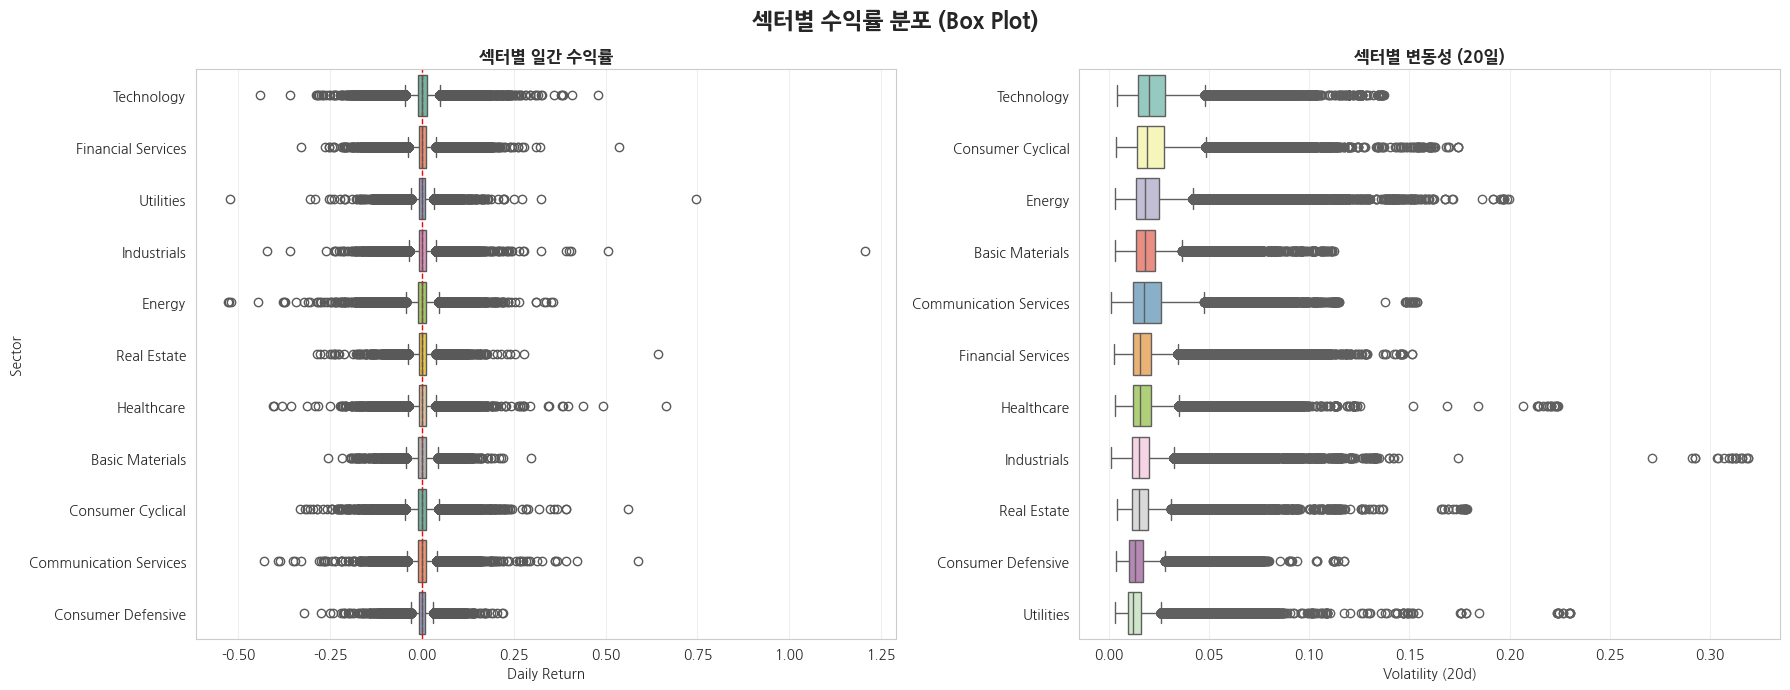

In [24]:
# 섹터별 수익률 분포
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('섹터별 수익률 분포 (Box Plot)', fontsize=16, fontweight='bold')

# 1. Daily Return
df_boxplot = df[df['Daily_Return'].notna()].copy()
sector_order = df_boxplot.groupby('Sector')['Daily_Return'].median().sort_values(ascending=False).index

sns.boxplot(data=df_boxplot, y='Sector', x='Daily_Return', order=sector_order, ax=axes[0], palette='Set2')
axes[0].set_title('섹터별 일간 수익률', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Sector')
axes[0].axvline(0, color='red', linestyle='--', linewidth=1)
axes[0].grid(True, alpha=0.3, axis='x')

# 2. Volatility
df_vol = df[df['Volatility_20d'].notna()].copy()
sector_order_vol = df_vol.groupby('Sector')['Volatility_20d'].median().sort_values(ascending=False).index

sns.boxplot(data=df_vol, y='Sector', x='Volatility_20d', order=sector_order_vol, ax=axes[1], palette='Set3')
axes[1].set_title('섹터별 변동성 (20일)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Volatility (20d)')
axes[1].set_ylabel('')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(VIZ_DIR / '02_boxplot_sector.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Section 3. Group 2 - 관계 분석

### 3.1 산점도 - Risk vs Return

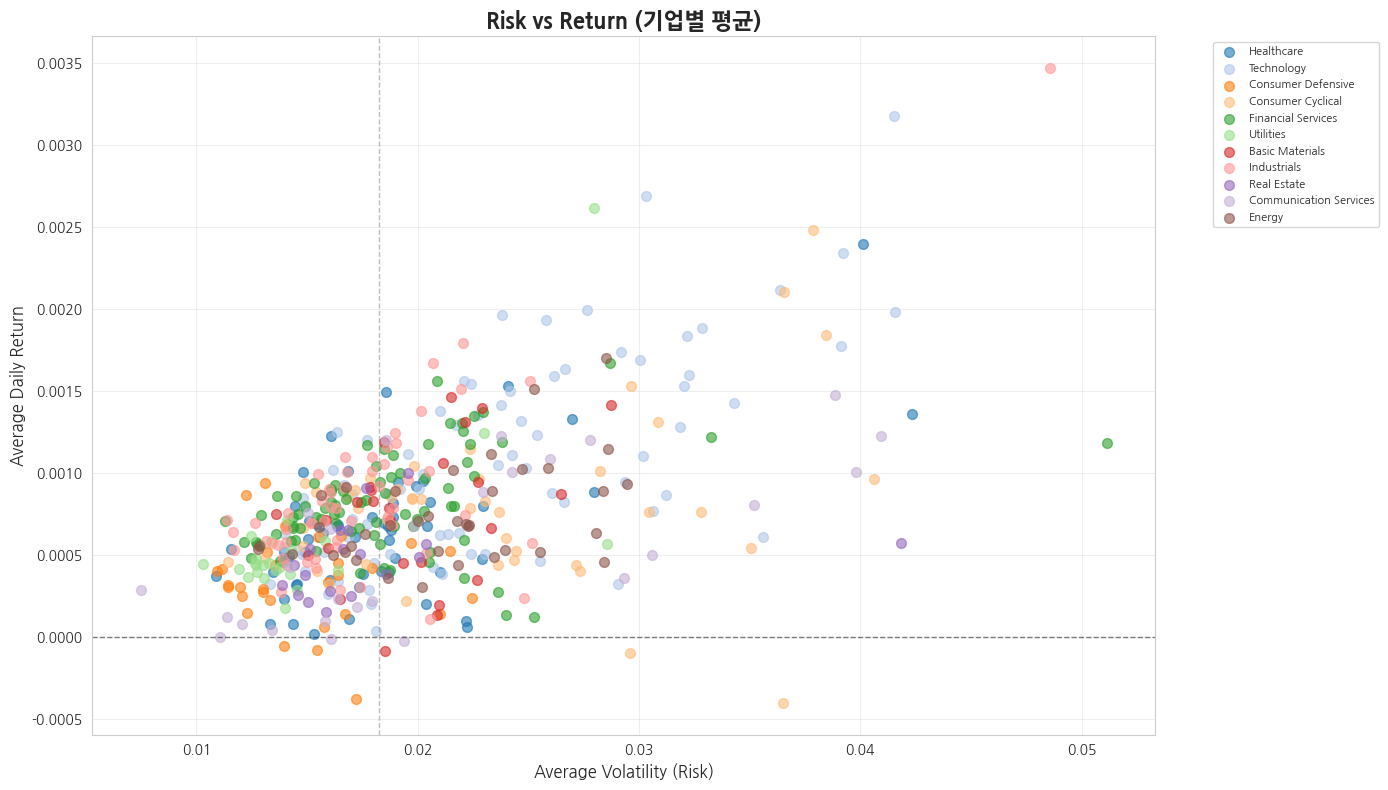

In [25]:
# 기업별 평균 수익률 vs 변동성
company_stats = df.groupby('Company').agg({
    'Daily_Return': 'mean',
    'Volatility_20d': 'mean',
    'Sector': 'first'
}).reset_index()

company_stats.columns = ['Company', 'Avg_Return', 'Avg_Volatility', 'Sector']
company_stats = company_stats.dropna()

# 산점도
plt.figure(figsize=(14, 8))
sectors = company_stats['Sector'].unique()
colors = sns.color_palette('tab20', len(sectors))

for sector, color in zip(sectors, colors):
    sector_data = company_stats[company_stats['Sector'] == sector]
    plt.scatter(sector_data['Avg_Volatility'], sector_data['Avg_Return'], 
                label=sector, alpha=0.6, s=50, color=color)

plt.title('Risk vs Return (기업별 평균)', fontsize=16, fontweight='bold')
plt.xlabel('Average Volatility (Risk)', fontsize=12)
plt.ylabel('Average Daily Return', fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.axvline(company_stats['Avg_Volatility'].median(), color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(VIZ_DIR / '04_scatter_risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Tableau용 데이터 저장
company_stats.to_csv(TABLEAU_DIR / 'risk_return_scatter.csv', index=False)

### 3.3 정규성 검정

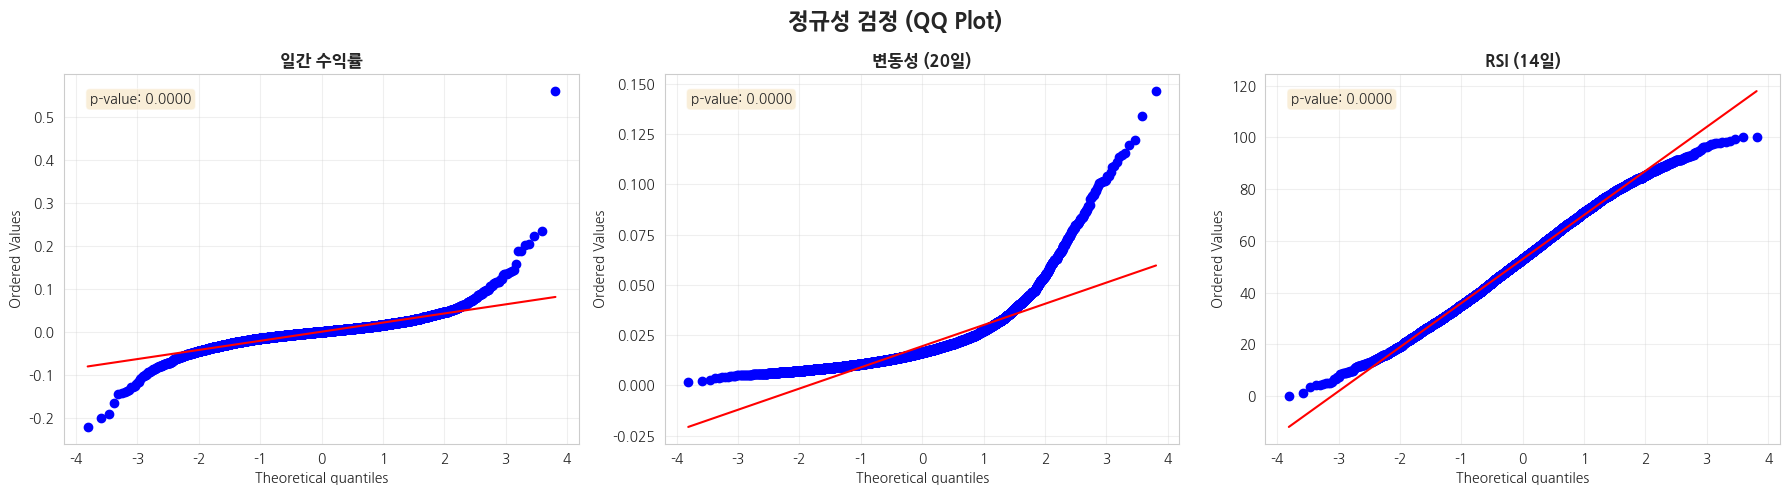

In [27]:
# QQ Plot for Daily_Return
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('정규성 검정 (QQ Plot)', fontsize=16, fontweight='bold')

variables_qq = [
    ('Daily_Return', '일간 수익률'),
    ('Volatility_20d', '변동성 (20일)'),
    ('RSI_14', 'RSI (14일)')
]

qq_data_list = []

for idx, (col, title) in enumerate(variables_qq):
    ax = axes[idx]
    data = df[col].dropna().sample(min(10000, len(df[col].dropna())))  # 샘플링
    
    # QQ Plot
    stats.probplot(data, dist="norm", plot=ax)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 정규성 검정 (Shapiro-Wilk)
    stat, p_value = normaltest(data)
    ax.text(0.05, 0.95, f'p-value: {p_value:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Tableau용 데이터 저장
    sorted_data = np.sort(data)
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(sorted_data)))
    
    qq_df = pd.DataFrame({
        'Variable': col,
        'Theoretical_Quantiles': theoretical_quantiles,
        'Sample_Quantiles': sorted_data
    })
    qq_data_list.append(qq_df)

plt.tight_layout()
plt.savefig(VIZ_DIR / '06_qqplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [28]:
# Tableau용 QQ Plot 데이터 저장
qq_all = pd.concat(qq_data_list, ignore_index=True)
qq_all.to_csv(TABLEAU_DIR / 'qqplot_data.csv', index=False)

### 결과 해석
* **결과**: 모든 변수의 p-value가 0.0000으로, 정규분포 가설이 기각됨.
* **Daily Return**: 전형적인 **Fat-Tail** 분포 확인. 극단적인 폭락장이 정규분포 예측보다 빈번함.
* **Volatility**: 오른쪽으로 긴 꼬리를 가진 왜도 분포. 모델링 시 **로그 변환** 고려 필요.
* **RSI**: 0~100 범위 제한으로 인한 S자 분포. 과매수/과매도 구간의 희소성 확인.
=> **결론**: 비정규적 특성을 반영하기 위해 Robust Scaling 또는 비모수적 머신러닝 모델(Prophet/K-Means) 적용 타당성 확보.

### 3.4 상관관계 히트맵

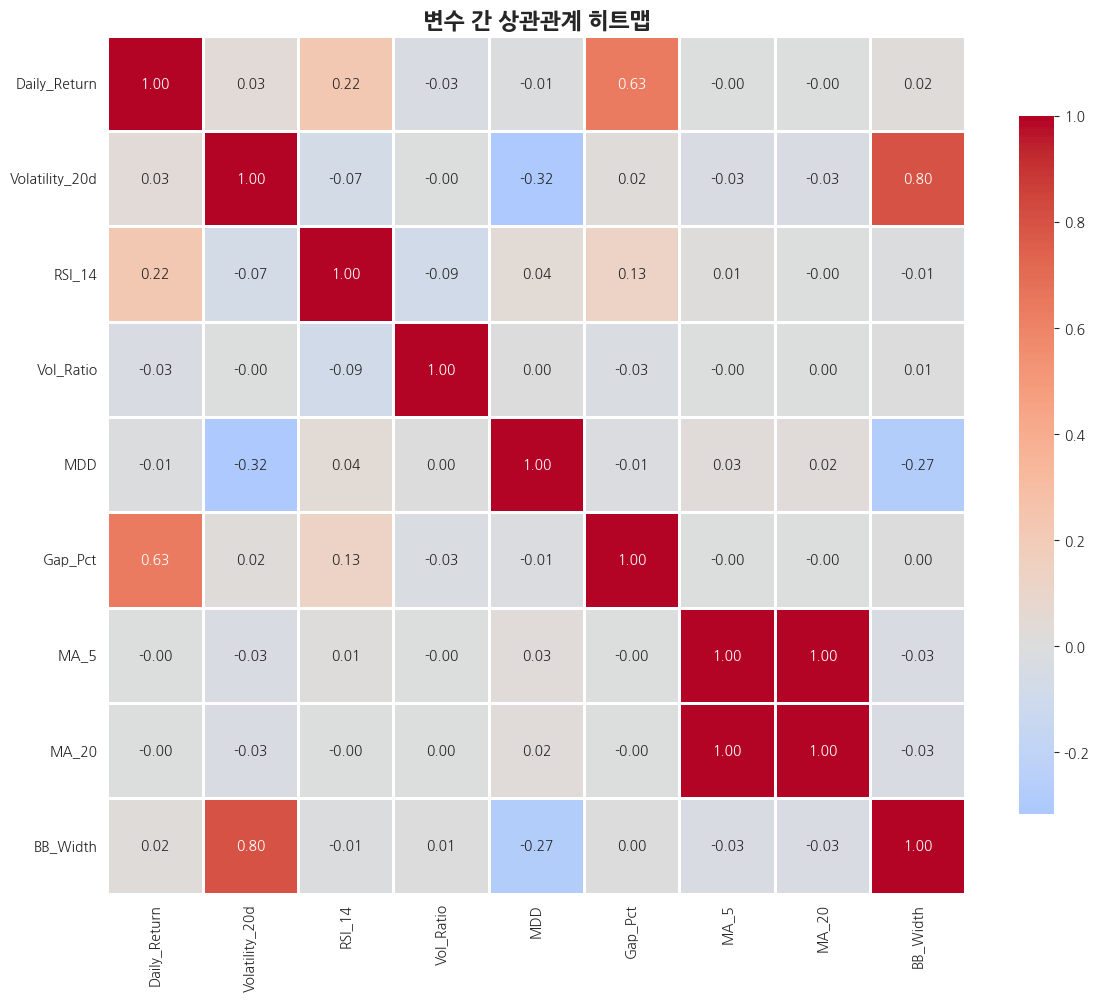

In [29]:
# 주요 변수 선택
corr_vars = [
    'Daily_Return', 'Volatility_20d', 'RSI_14', 'Vol_Ratio', 
    'MDD', 'Gap_Pct', 'MA_5', 'MA_20', 'BB_Width'
]

df_corr = df[corr_vars].dropna()
correlation_matrix = df_corr.corr()

# 히트맵
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('변수 간 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(VIZ_DIR / '07_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [30]:
# Tableau용 상관계수 행렬 변환
corr_stacked = correlation_matrix.stack().reset_index()
corr_stacked.columns = ['Variable_1', 'Variable_2', 'Correlation']
corr_stacked.to_csv(TABLEAU_DIR / 'correlation_matrix.csv', index=False)

---

## Section 4. Group 3 - 시계열

### 4.1 시계열 분해

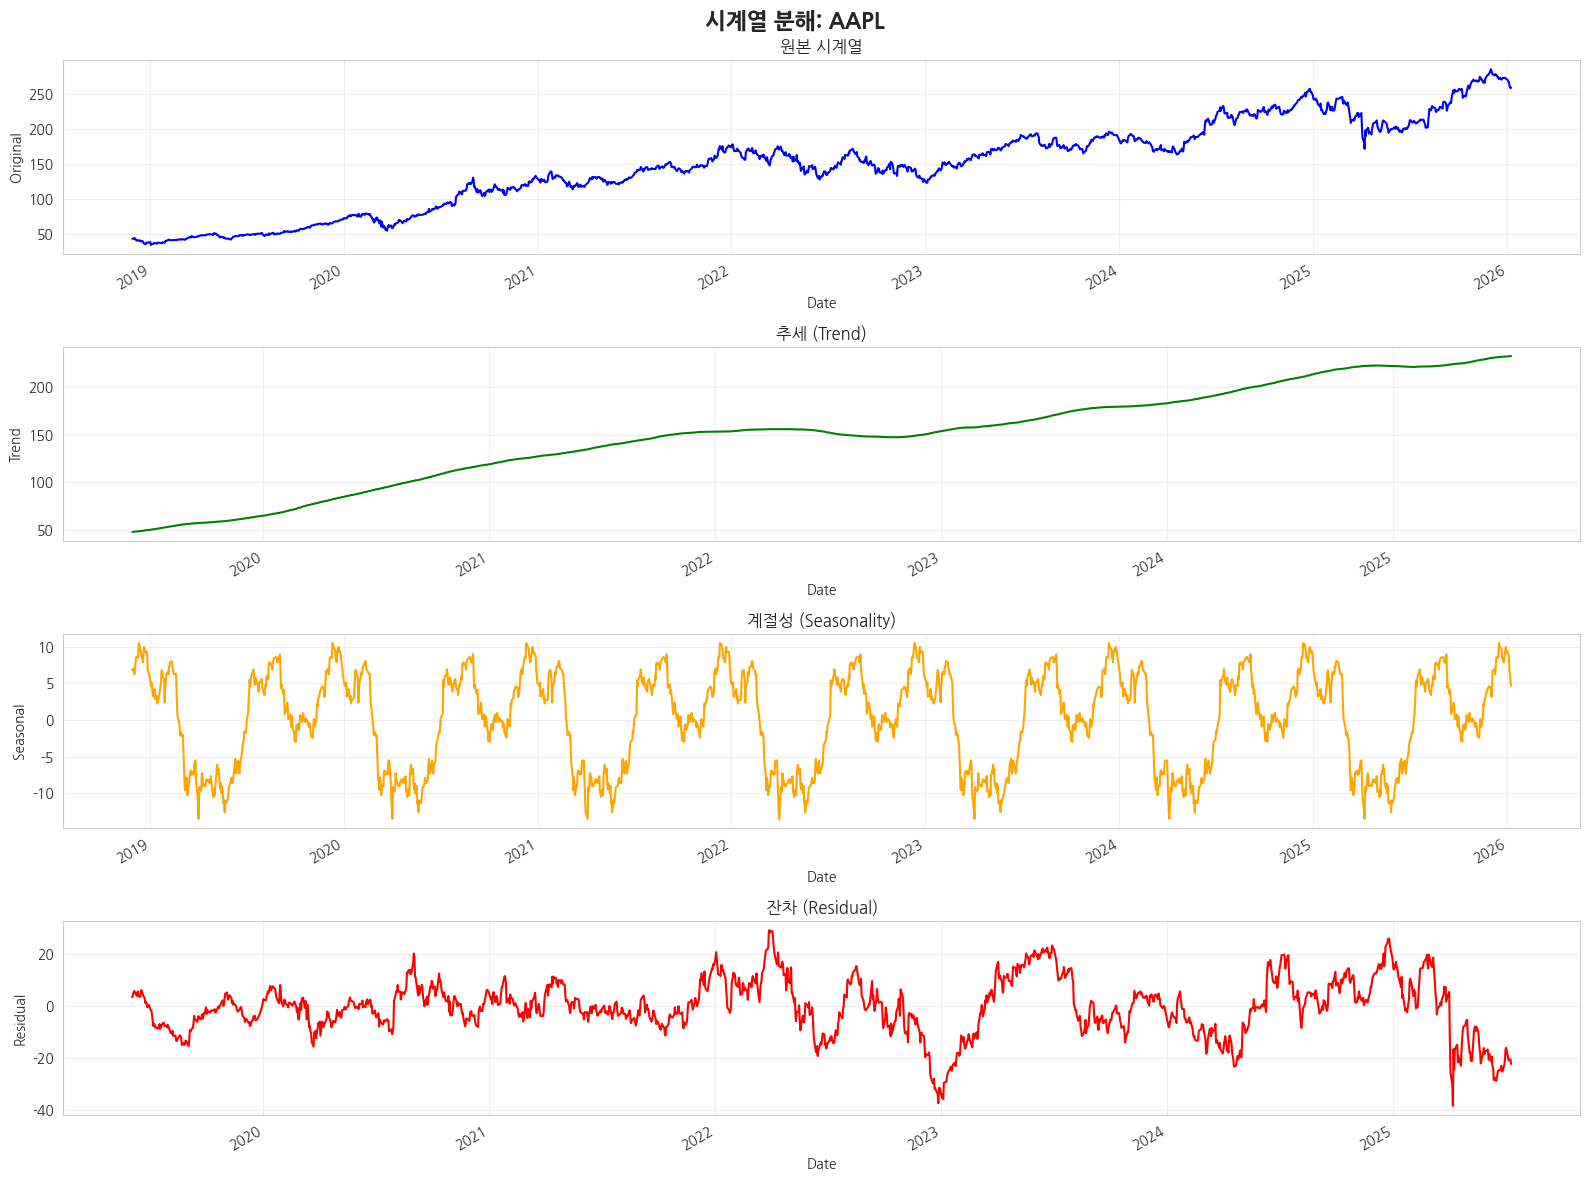

In [31]:
# 대표 기업 선택 (AAPL)
sample_ticker = 'AAPL'
df_ts = df[df['Company'] == sample_ticker].copy()
df_ts = df_ts.set_index('Date').sort_index()

# 시계열 분해 (Additive)
decomposition = seasonal_decompose(df_ts['Close'], model='additive', period=252)  # 연간 주기

# 시각화
fig, axes = plt.subplots(4, 1, figsize=(16, 12))
fig.suptitle(f'시계열 분해: {sample_ticker}', fontsize=16, fontweight='bold')

decomposition.observed.plot(ax=axes[0], color='blue')
axes[0].set_ylabel('Original')
axes[0].set_title('원본 시계열')
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='green')
axes[1].set_ylabel('Trend')
axes[1].set_title('추세 (Trend)')
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='orange')
axes[2].set_ylabel('Seasonal')
axes[2].set_title('계절성 (Seasonality)')
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_ylabel('Residual')
axes[3].set_title('잔차 (Residual)')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / f'08_decomposition_{sample_ticker}.png', dpi=300, bbox_inches='tight')
plt.show()


In [32]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# 결과를 담을 리스트
adf_results = []
tickers = df['Company'].unique()

for ticker in tickers:
    series = df[df['Company'] == ticker]['Close'].dropna()
    
    # 데이터가 너무 적으면 패스
    if len(series) < 100: continue
        
    # ADF Test 수행
    result = adfuller(series)
    p_value = result[1]
    
    # p-value가 0.05보다 크면 "추세가 있다(비정상)"고 판단
    has_trend = p_value > 0.05 
    
    adf_results.append({
        'Company': ticker,
        'p_value': p_value,
        'Has_Trend': has_trend
    })

# 데이터프레임 변환
adf_df = pd.DataFrame(adf_results)

# 결론 도출
trend_count = adf_df['Has_Trend'].sum()
print("="*50)
print(f"분석 결과 요약:")
print(f"- 전체 종목 수: {len(adf_df)}")
print(f"- 추세가 있는 종목 (비정상 시계열): {trend_count}개 ({trend_count/len(adf_df)*100:.1f}%)")
print(f"- 추세가 없는 종목 (박스권/랜덤): {len(adf_df) - trend_count}개")
print("="*50)

분석 결과 요약:
- 전체 종목 수: 481
- 추세가 있는 종목 (비정상 시계열): 465개 (96.7%)
- 추세가 없는 종목 (박스권/랜덤): 16개


In [33]:
# 추세가 없는 (Has_Trend == False) 종목만 필터링
no_trend_df = adf_df[adf_df['Has_Trend'] == False].sort_values('p_value')

print(f"추세 없는 종목 수: {len(no_trend_df)}개")
print("-" * 50)
print(no_trend_df)

# 리스트로 저장해두기
no_trend_tickers = no_trend_df['Company'].values

추세 없는 종목 수: 16개
--------------------------------------------------
    Company   p_value  Has_Trend
322       O  0.004577      False
52      BDX  0.014031      False
255      LI  0.018017      False
263     LVS  0.020808      False
248     KMB  0.024169      False
146      EC  0.024631      False
184     FTV  0.024680      False
113    CSGP  0.025515      False
106    CPNG  0.026235      False
27      AMT  0.027964      False
187    GEHC  0.029182      False
41      AWK  0.033650      False
31      APD  0.035250      False
333     PCG  0.042165      False
377    SBUX  0.045276      False
407     TAK  0.048748      False


### 결과 해석

**1. 압도적인 추세 존재**
* 전체 분석 대상의 **96.7%(475개)** 가 '비정상 시계열'로 판명됨.
* 이는 주요 우량주들이 무작위로 움직이는 것이 아니라, **명확한 장기적 추세와 관성**을 가지고 움직임을 시사함.
* => **전략 수립:** 추세 추종형 모델인 **Facebook Prophet**을 메인 예측 모델로 채택하는 것에 대한 강력한 통계적 타당성 확보.

**2. 소수의 박스권 종목**
* 나머지 **3.3%(16개)** 는 추세가 없는 '정상 시계열'로 나타남.
* 이들은 장기적 상승/하락보다는 일정 가격대에서 횡보하는 성향이 강함.
* => **전략 수립:** 추후 K-Means 클러스터링 시 별도의 '저변동성/안정형' 그룹으로 분류될 가능성이 높으며, 추세 매매보다는 박스권 매매 전략이 유효함.

### 분석 결과

* **Trend**: 2023년 이후 강력한 우상향 추세가 확인됨. Prophet 모델의 예측 성능이 높을 것으로 기대됨.
* **Seasonality**: 연간(`period=252`) 기준의 주기적 패턴이 존재함. 이는 애플의 제품 출시 사이클(Q3/Q4)과 연관될 가능성 있음.
* **Residual**: 특정 시점(2022년 하락장 등)에 모델이 설명하지 못하는 변동성이 존재하나, 전체적으로 안정적인 분포를 보임.

In [34]:
# Tableau용 분해 데이터 저장
decomp_df = pd.DataFrame({
    'Date': decomposition.observed.index,
    'Original': decomposition.observed.values,
    'Trend': decomposition.trend.values,
    'Seasonal': decomposition.seasonal.values,
    'Residual': decomposition.resid.values,
    'Company': sample_ticker
})
decomp_df.to_csv(TABLEAU_DIR / f'decomposition_{sample_ticker}.csv', index=False)

### 4.2 ACF / PACF Plot (자기상관함수)

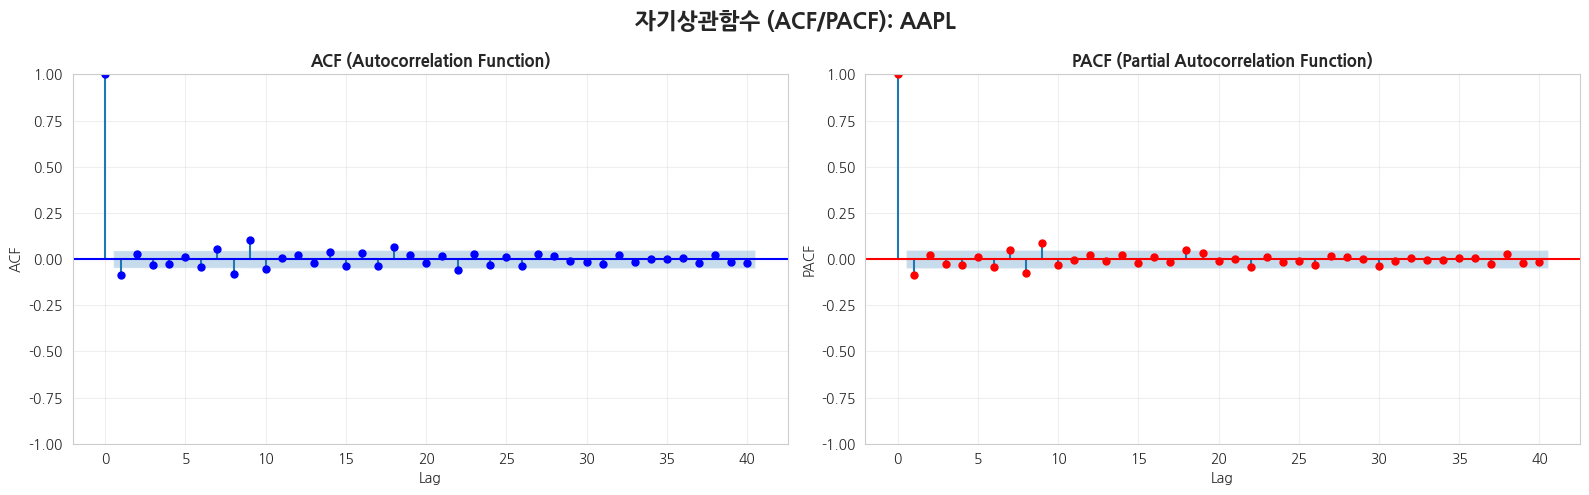

In [35]:
# ACF / PACF 계산
returns = df_ts['Daily_Return'].dropna()
lags = 40

# ACF
acf_values = acf(returns, nlags=lags, fft=True)

# PACF
pacf_values = pacf(returns, nlags=lags, method='ywm')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f'자기상관함수 (ACF/PACF): {sample_ticker}', fontsize=16, fontweight='bold')

# ACF Plot
plot_acf(returns, lags=lags, ax=axes[0], color='blue')
axes[0].set_title('ACF (Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')
axes[0].grid(True, alpha=0.3)

# PACF Plot
plot_pacf(returns, lags=lags, ax=axes[1], color='red', method='ywm')
axes[1].set_title('PACF (Partial Autocorrelation Function)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / f'09_acf_pacf_{sample_ticker}.png', dpi=300, bbox_inches='tight')
plt.show()


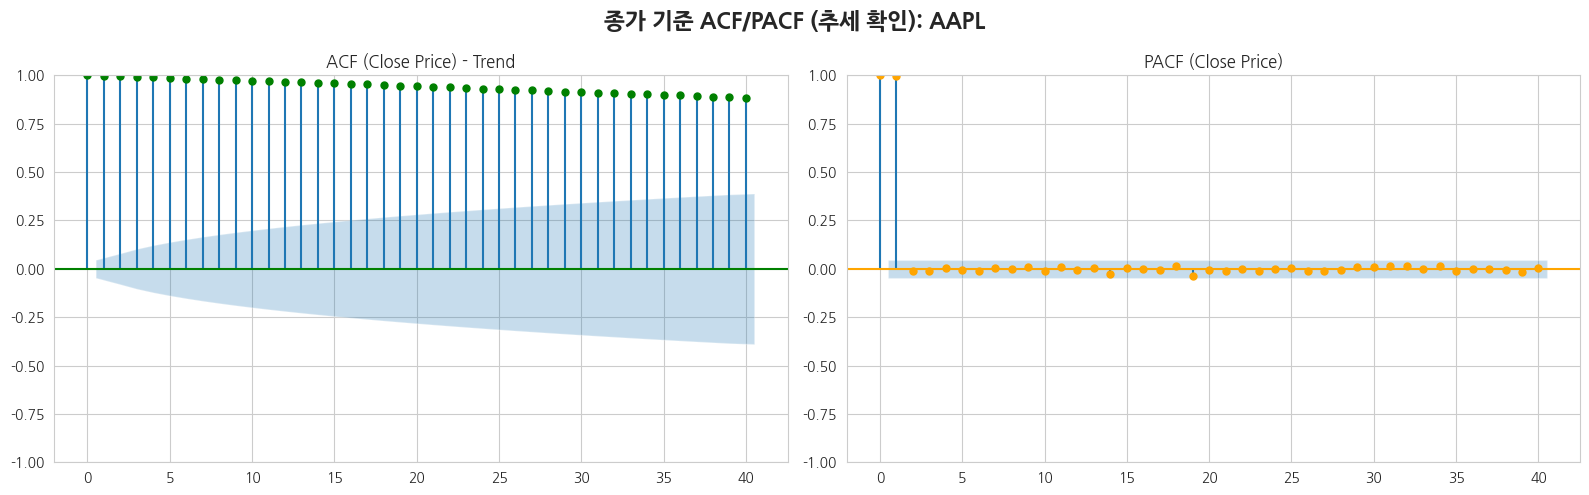

In [36]:
# 종가(Close) 기준 ACF/PACF 계산
prices = df_ts['Close'].dropna()

# ACF/PACF 계산
acf_price = acf(prices, nlags=lags, fft=True)
pacf_price = pacf(prices, nlags=lags, method='ywm')

# 시각화 (종가 기준)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle(f'종가 기준 ACF/PACF (추세 확인): {sample_ticker}', fontsize=16, fontweight='bold')

# ACF
plot_acf(prices, lags=lags, ax=axes[0], color='green')
axes[0].set_title('ACF (Close Price) - Trend', fontsize=12)

# PACF (Lag 1만 튀어나와야 정상)
plot_pacf(prices, lags=lags, ax=axes[1], color='orange', method='ywm')
axes[1].set_title('PACF (Close Price)', fontsize=12)

plt.tight_layout()
plt.show()

* **ACF (AutoCorrelation Function)**: 시차(Lag)에 따른 관측치 간의 연관성. 추세가 강할수록 천천히 감소함.
* **PACF (Partial AutoCorrelation Function)**: 다른 시차의 영향을 배제한 순수한 연관성. AR 모델의 차수($p$)를 결정하는 기준.

### 종가 분석 결과
* **현상**: ACF가 시차가 늘어남에 따라 아주 천천히 감소하는 형태를 보임. PACF는 Lag 1에서만 강한 값을 갖고 이후 절단됨.
* **해석**: 
    * 전형적인 **비정상 시계열** 데이터임.
    * 강한 **추세**와 관성을 가지고 있음.
    * $P_t \approx P_{t-1}$의 성향이 강하므로, 과거 데이터를 기반으로 한 추세 예측 모델이 유효함.

### 수익률 분석 결과
* **현상**: ACF와 PACF 모두 Lag 0을 제외하고는 파란색 신뢰구간(95% Confidence Interval) 내에 머무름.
* **해석**: 
    * 전형적인 **백색 잡음** 형태.
    * 통계적으로 **정상성** 을 만족함.
    * 이는 **'효율적 시장 가설'** 을 뒷받침하며, 단순한 과거 수익률 패턴만으로는 미래 수익률을 예측하기 어려움을 시사함.

---

In [37]:
# [Tableau Export] 수익률 vs 종가 데이터 통합 저장

# 1. 수익률 데이터 (Return)
df_return_stats = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'ACF': acf_values,
    'PACF': pacf_values,
    'Type': 'Daily_Return', # 구분자 추가
    'Company': sample_ticker
})

# 2. 종가 데이터 (Close)
df_price_stats = pd.DataFrame({
    'Lag': range(len(acf_price)),
    'ACF': acf_price,
    'PACF': pacf_price,
    'Type': 'Close_Price', # 구분자 추가
    'Company': sample_ticker
})

# 3. 병합 및 저장
final_stats_df = pd.concat([df_return_stats, df_price_stats], ignore_index=True)
final_stats_df.to_csv(TABLEAU_DIR / f'acf_pacf_combined_{sample_ticker}.csv', index=False)

print(f"Tableau용 통합 데이터 저장 완료: {len(final_stats_df)} rows")

Tableau용 통합 데이터 저장 완료: 82 rows


---

## Section 5. Group 4 - 섹터/기업 비교

### 5.1 Sector Performance Heatmap

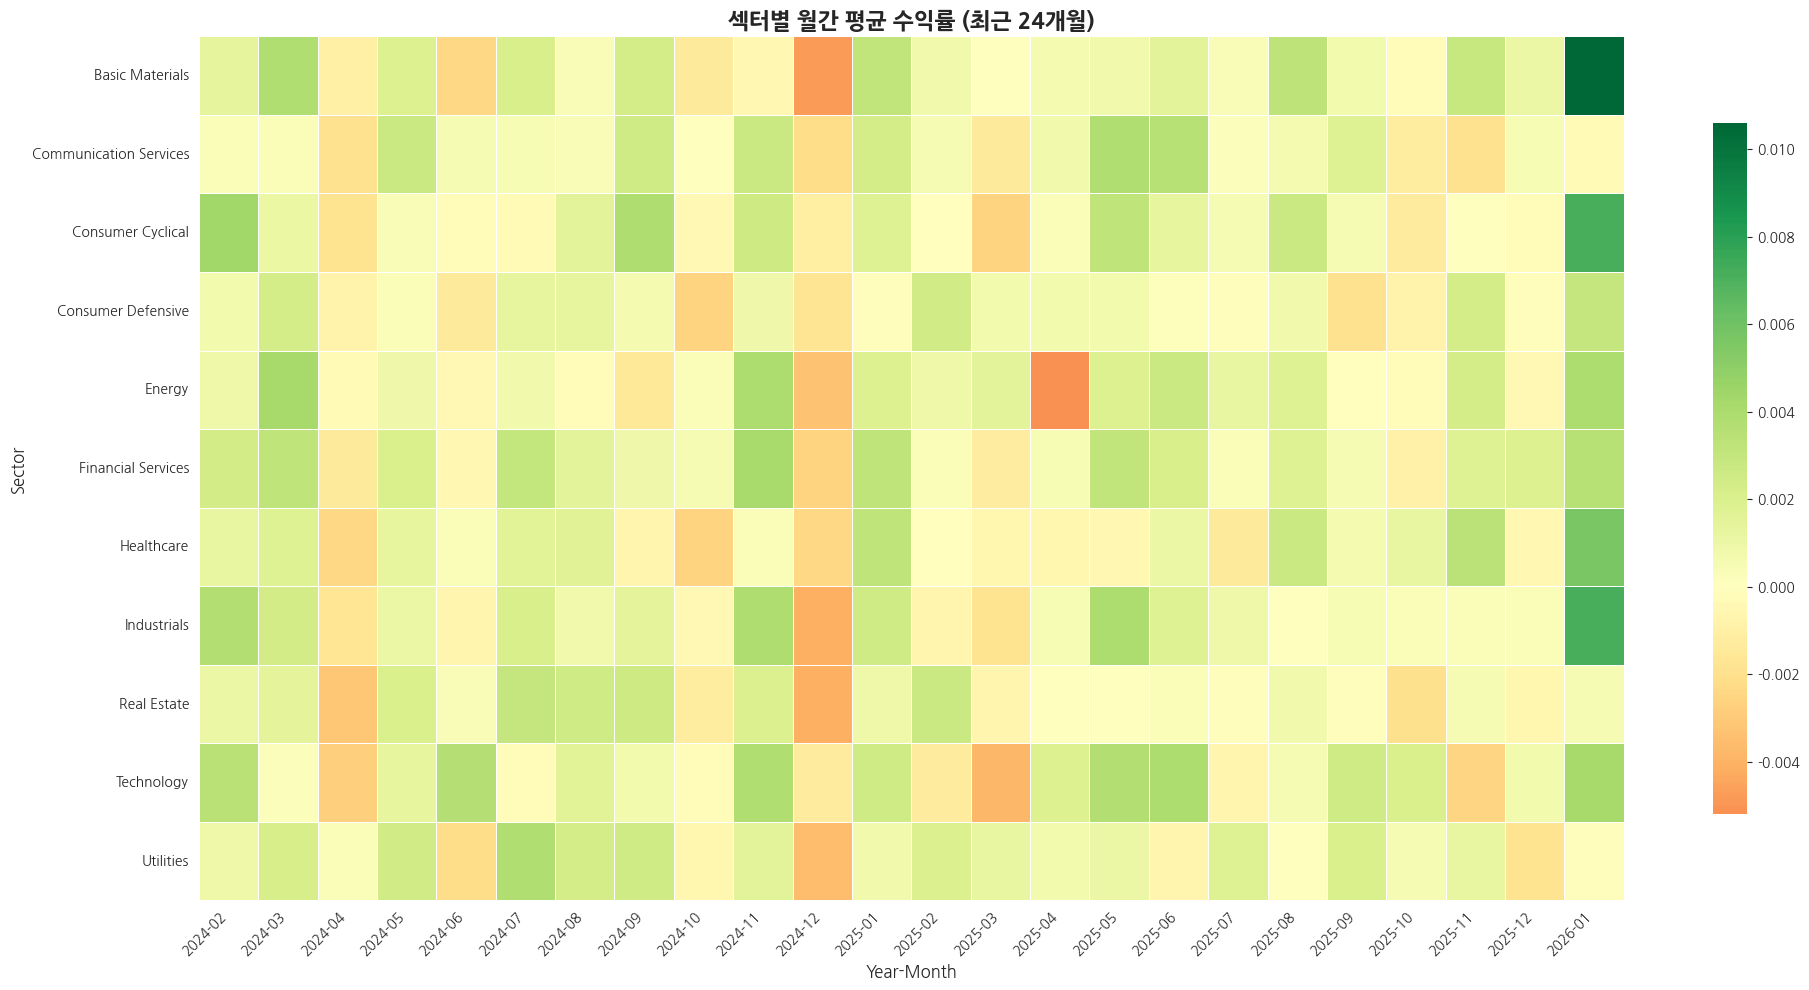

In [38]:
# 월별 섹터 성과
df['Year_Month'] = df['Date'].dt.to_period('M')
sector_monthly = df.groupby(['Year_Month', 'Sector'])['Daily_Return'].mean().reset_index()
sector_pivot = sector_monthly.pivot(index='Sector', columns='Year_Month', values='Daily_Return')

# 최근 24개월만 표시
sector_pivot_recent = sector_pivot.iloc[:, -24:]

# 히트맵
plt.figure(figsize=(20, 10))
sns.heatmap(sector_pivot_recent, annot=False, cmap='RdYlGn', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('섹터별 월간 평균 수익률 (최근 24개월)', fontsize=16, fontweight='bold')
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(VIZ_DIR / '10_sector_performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
# Tableau용 데이터 저장
sector_monthly['Year_Month'] = sector_monthly['Year_Month'].astype(str)
sector_monthly.to_csv(TABLEAU_DIR / 'sector_monthly_performance.csv', index=False)

### 5.2 Top/Bottom Performers

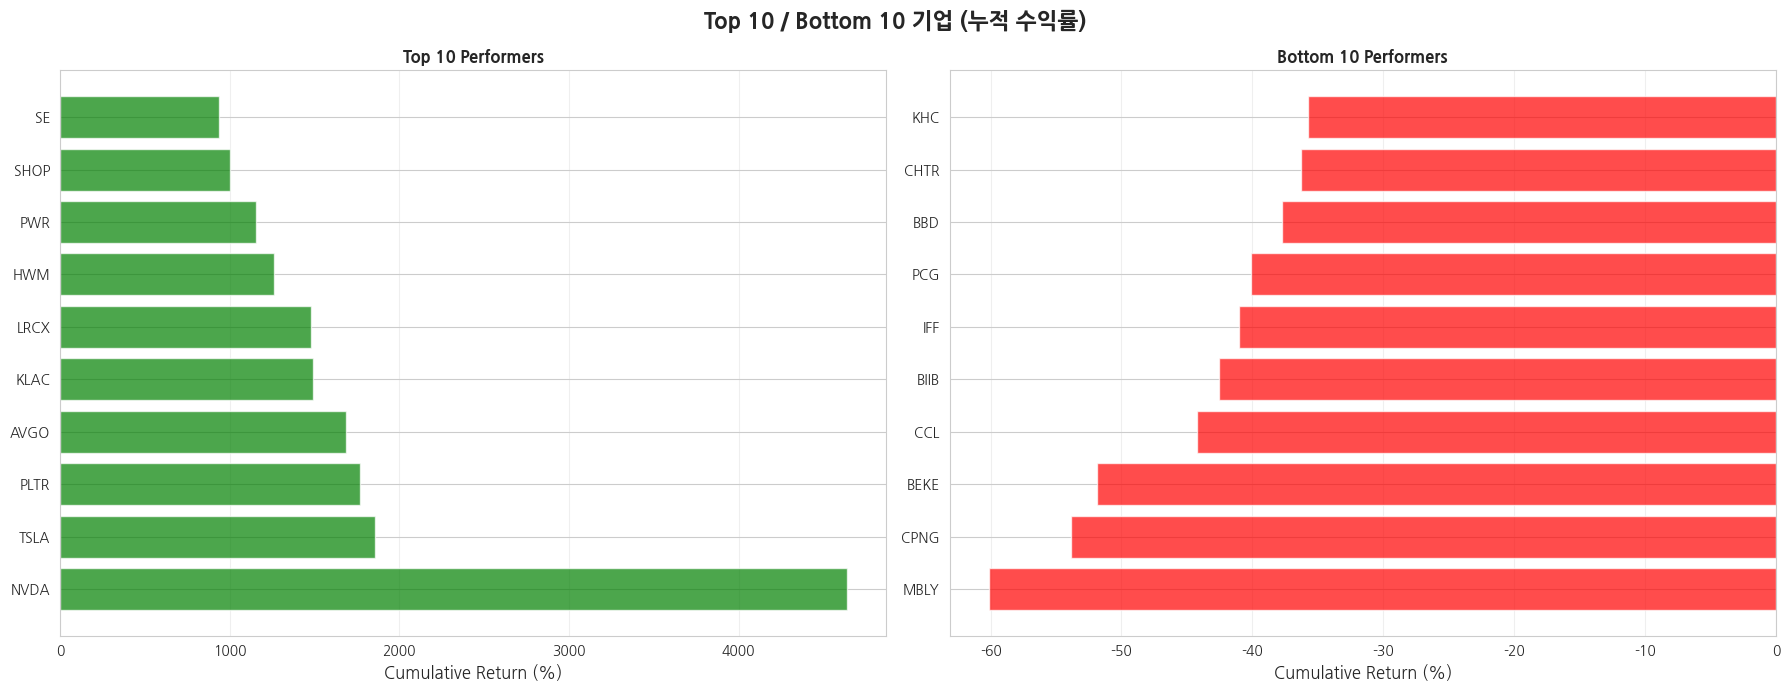

In [40]:
# 기업별 누적 수익률 계산
company_cumret = df.groupby('Company').agg({
    'Cum_Return': 'last',  # 마지막 누적 수익률
    'Volatility_20d': 'mean',
    'Sector': 'first',
    'MDD': 'min'  # 최대 낙폭
}).reset_index()

company_cumret = company_cumret.dropna()

# Top 10 / Bottom 10
top10 = company_cumret.nlargest(10, 'Cum_Return')
bottom10 = company_cumret.nsmallest(10, 'Cum_Return')

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Top 10 / Bottom 10 기업 (누적 수익률)', fontsize=16, fontweight='bold')

# Top 10
axes[0].barh(top10['Company'], top10['Cum_Return'] * 100, color='green', alpha=0.7)
axes[0].set_xlabel('Cumulative Return (%)', fontsize=12)
axes[0].set_title('Top 10 Performers', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Bottom 10
axes[1].barh(bottom10['Company'], bottom10['Cum_Return'] * 100, color='red', alpha=0.7)
axes[1].set_xlabel('Cumulative Return (%)', fontsize=12)
axes[1].set_title('Bottom 10 Performers', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(VIZ_DIR / '11_top_bottom_performers.png', dpi=300, bbox_inches='tight')
plt.show()


In [41]:
# Tableau용 데이터 저장
performers = pd.concat([top10, bottom10], ignore_index=True)
performers.to_csv(TABLEAU_DIR / 'top_bottom_performers.csv', index=False)

### 5.3 Risk-Return Scatter (섹터별 컬러링)

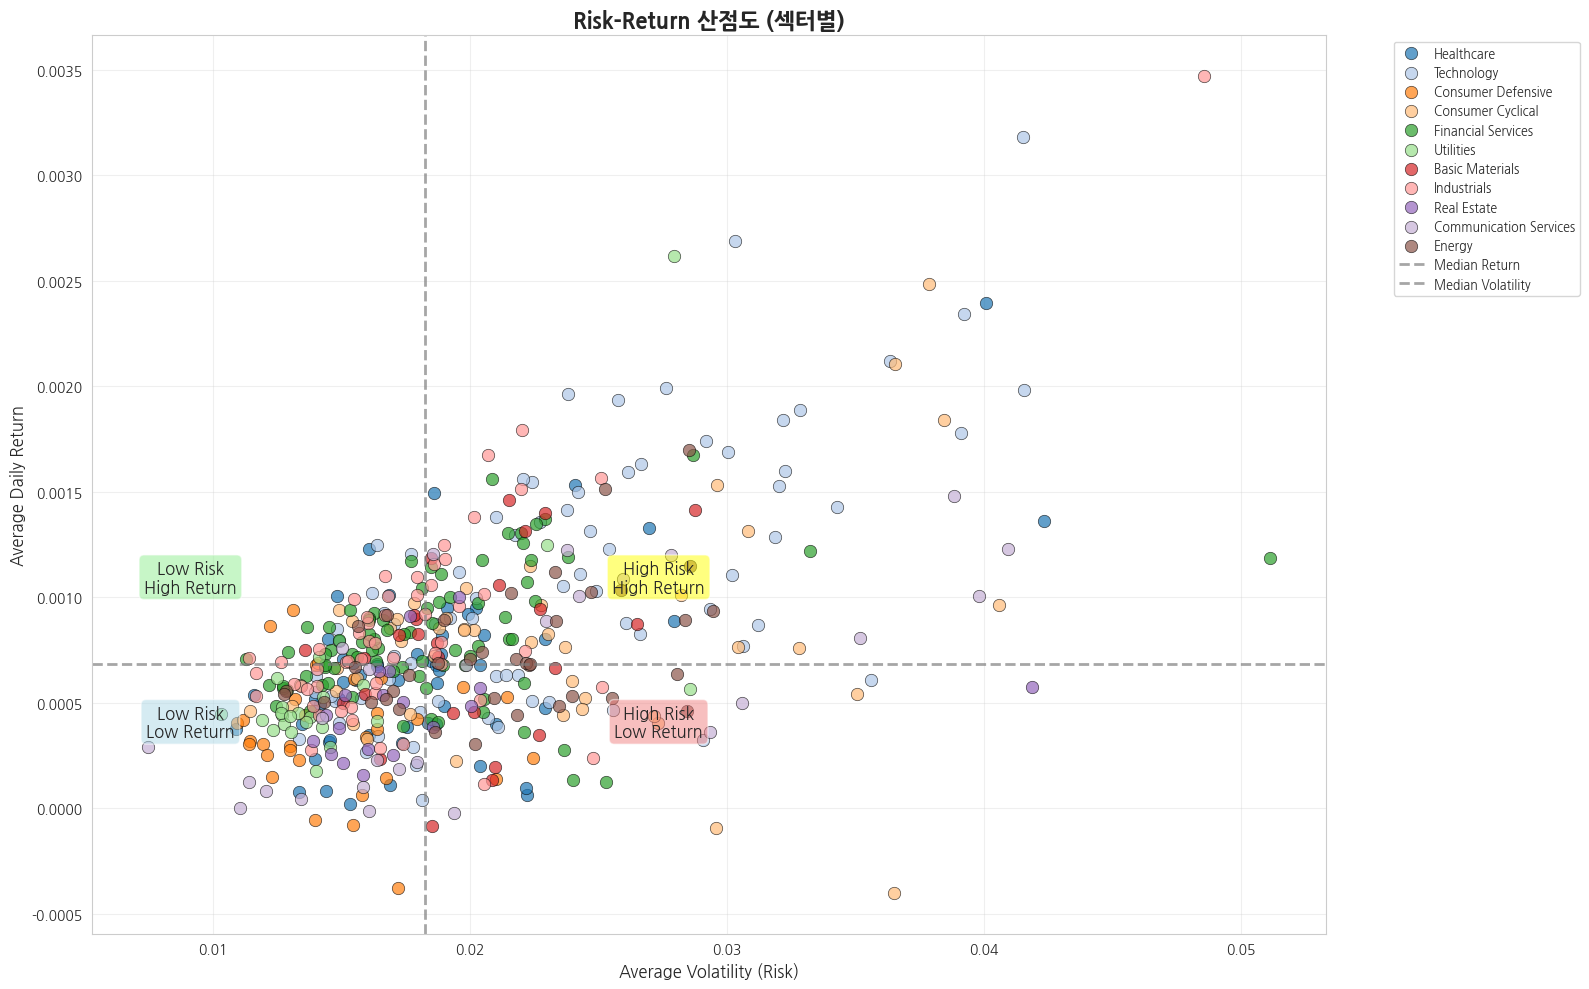

In [42]:
# 기업별 평균 계산
company_risk_return = df.groupby('Company').agg({
    'Daily_Return': 'mean',
    'Volatility_20d': 'mean',
    'Sector': 'first'
}).reset_index()

company_risk_return.columns = ['Company', 'Avg_Return', 'Avg_Volatility', 'Sector']
company_risk_return = company_risk_return.dropna()

# 산점도 (섹터별 컬러링)
plt.figure(figsize=(16, 10))
sectors_unique = company_risk_return['Sector'].unique()
colors = sns.color_palette('tab20', len(sectors_unique))

for sector, color in zip(sectors_unique, colors):
    sector_data = company_risk_return[company_risk_return['Sector'] == sector]
    plt.scatter(sector_data['Avg_Volatility'], sector_data['Avg_Return'], 
                label=sector, alpha=0.7, s=80, color=color, edgecolors='black', linewidth=0.5)

# 사분면 구분선
median_return = company_risk_return['Avg_Return'].median()
median_vol = company_risk_return['Avg_Volatility'].median()

plt.axhline(median_return, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Median Return')
plt.axvline(median_vol, color='gray', linestyle='--', linewidth=2, alpha=0.7, label='Median Volatility')

# 사분면 라벨
plt.text(median_vol * 0.5, median_return * 1.5, 'Low Risk\nHigh Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
plt.text(median_vol * 1.5, median_return * 1.5, 'High Risk\nHigh Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
plt.text(median_vol * 0.5, median_return * 0.5, 'Low Risk\nLow Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.text(median_vol * 1.5, median_return * 0.5, 'High Risk\nLow Return', 
         fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.title('Risk-Return 산점도 (섹터별)', fontsize=16, fontweight='bold')
plt.xlabel('Average Volatility (Risk)', fontsize=12)
plt.ylabel('Average Daily Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(VIZ_DIR / '12_risk_return_quadrant.png', dpi=300, bbox_inches='tight')
plt.show()

---

## Section 6. 최종 요약 및 인사이트

In [43]:
# 탑다운 전략을 위한 핵심 인사이트 추출

# 1. 섹터 성과 순위
sector_performance = df.groupby('Sector')['Daily_Return'].mean().sort_values(ascending=False)
print("\n섹터 평균 수익률 (Top 5):")
for i, (sector, ret) in enumerate(sector_performance.head(5).items(), 1):
    print(f"  {i}. {sector}: {ret*100:.4f}%")

# 2. 저변동성 고수익 기업
# 조건: 평균 수익률 > 중앙값, 변동성 < 중앙값
low_vol_high_ret = company_risk_return[
    (company_risk_return['Avg_Return'] > median_return) & 
    (company_risk_return['Avg_Volatility'] < median_vol)
].sort_values('Avg_Return', ascending=False).head(5)

print("\n Top 5 Picks 후보 (저변동성 고수익):")
for i, row in enumerate(low_vol_high_ret.itertuples(), 1):
    print(f"  {i}. {row.Company} ({row.Sector})")
    print(f"     - 평균 수익률: {row.Avg_Return*100:.4f}%")
    print(f"     - 평균 변동성: {row.Avg_Volatility*100:.4f}%")

# 3. 고위험 고수익 기업 (공격적 투자 후보)
high_risk_high_ret = company_risk_return[
    (company_risk_return['Avg_Return'] > median_return) & 
    (company_risk_return['Avg_Volatility'] > median_vol)
].sort_values('Avg_Return', ascending=False).head(5)

print("\n 공격적 투자 후보 (고위험 고수익):")
for i, row in enumerate(high_risk_high_ret.itertuples(), 1):
    print(f"  {i}. {row.Company} ({row.Sector})")
    print(f"     - 평균 수익률: {row.Avg_Return*100:.4f}%")
    print(f"     - 평균 변동성: {row.Avg_Volatility*100:.4f}%")

print("\n" + "=" * 70)


섹터 평균 수익률 (Top 5):
  1. Technology: 0.1059%
  2. Industrials: 0.0824%
  3. Consumer Cyclical: 0.0819%
  4. Financial Services: 0.0805%
  5. Basic Materials: 0.0752%

 Top 5 Picks 후보 (저변동성 고수익):
  1. APH (Technology)
     - 평균 수익률: 0.1249%
     - 평균 변동성: 1.6373%
  2. MCK (Healthcare)
     - 평균 수익률: 0.1230%
     - 평균 변동성: 1.6074%
  3. AAPL (Technology)
     - 평균 수익률: 0.1204%
     - 평균 변동성: 1.7704%
  4. GS (Financial Services)
     - 평균 수익률: 0.1171%
     - 평균 변동성: 1.7707%
  5. TT (Industrials)
     - 평균 수익률: 0.1101%
     - 평균 변동성: 1.6706%

 공격적 투자 후보 (고위험 고수익):
  1. SYM (Industrials)
     - 평균 수익률: 0.3468%
     - 평균 변동성: 4.8572%
  2. PLTR (Technology)
     - 평균 수익률: 0.3178%
     - 평균 변동성: 4.1523%
  3. NVDA (Technology)
     - 평균 수익률: 0.2687%
     - 평균 변동성: 3.0303%
  4. CEG (Utilities)
     - 평균 수익률: 0.2615%
     - 평균 변동성: 2.7951%
  5. TSLA (Consumer Cyclical)
     - 평균 수익률: 0.2483%
     - 평균 변동성: 3.7869%



In [44]:
# Top 5 Picks를 CSV로 저장
low_vol_high_ret.to_csv(TABLEAU_DIR / 'top5_picks.csv', index=False)
high_risk_high_ret.to_csv(TABLEAU_DIR / 'aggressive_picks.csv', index=False)